<a href="https://colab.research.google.com/github/iakovkh/mypython/blob/main/LSTM_example8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10
2401/2401 - 17s - 7ms/step - loss: 0.6605
Epoch 2/10
2401/2401 - 20s - 8ms/step - loss: 0.4721
Epoch 3/10
2401/2401 - 14s - 6ms/step - loss: 0.4674
Epoch 4/10
2401/2401 - 21s - 9ms/step - loss: 0.4608
Epoch 5/10
2401/2401 - 14s - 6ms/step - loss: 0.4592
Epoch 6/10
2401/2401 - 14s - 6ms/step - loss: 0.4568
Epoch 7/10
2401/2401 - 14s - 6ms/step - loss: 0.4510
Epoch 8/10
2401/2401 - 14s - 6ms/step - loss: 0.4463
Epoch 9/10
2401/2401 - 14s - 6ms/step - loss: 0.4474
Epoch 10/10
2401/2401 - 21s - 9ms/step - loss: 0.4473
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


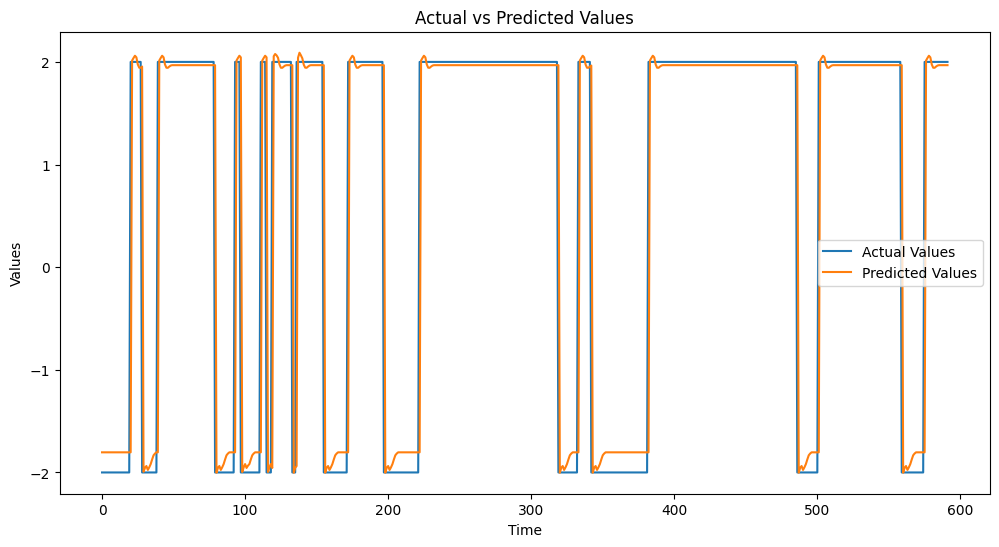

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Step 1: General data preparation
class MyMatrix:
    def __init__(self):
        self.data = None
        self.scaler = MinMaxScaler(feature_range=(0, 1))

    # 1.7: Method to read data from xlsx file
    def read_data_from_file(self, file_path):
        self.data = pd.read_excel(file_path)

    # 1.8: Method to normalize data
    def normalize_data(self, normalize=True):
        if normalize:
            self.data = pd.DataFrame(self.scaler.fit_transform(self.data), columns=self.data.columns)

    # 1.9: Method to display data in console
    def display_console(self, column=None):
        if column:
            print(self.data[column])
        else:
            print(self.data)

    # 1.10: Method to display data visually
    def display_visual(self, column=None):
        if column:
            plt.plot(self.data[column])
            plt.title(f'Column {column}')
            plt.show()
        else:
            for col in self.data.columns:
                plt.figure()
                plt.plot(self.data[col])
                plt.title(f'Column {col}')
                plt.show()

# Step 2: Read and prepare data
# 3.3: Create an object of MyMatrix class
my_data = MyMatrix()

# 3.4: Read the data from the file
my_data.read_data_from_file('/content/sample_data/NN.xlsx')

# 3.5: Use first 80% of the data for training and keep 20% for testing
train_size = int(len(my_data.data) * 0.8)
train_data = my_data.data.iloc[:train_size]
test_data = my_data.data.iloc[train_size:]

# 2.4: Normalize the data (optional)
normalize = False  # Set to False if you don't want to normalize the data
if normalize:
    my_data.scaler.fit(train_data)  # Fit the scaler on the training data
    train_data = pd.DataFrame(my_data.scaler.transform(train_data), columns=my_data.data.columns)
    test_data = pd.DataFrame(my_data.scaler.transform(test_data), columns=my_data.data.columns)

# 3.6: Reshape the data for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
train_data = train_data.values
test_data = test_data.values

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 3.7: Create an LSTM neural network
epochs = 10
neurons = 40

model = Sequential()
model.add(Input(shape=(time_step, 1)))  # Define the input shape using Input layer
model.add(LSTM(neurons, return_sequences=True))
model.add(LSTM(neurons, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 3.8: Train the LSTM neural network using only the training data
model.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=2)

# Step 4: Testing results
# 4.1: Forecast values using the trained LSTM neural network on testing data only
train_predict = model.predict(X_train)  # This is for training data, not used for forecasting
test_predict = model.predict(X_test)    # This is for testing data, used for forecasting

# Inverse transform to get actual values for the first column
if normalize:
    train_predict = my_data.scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], my_data.data.shape[1] - 1))), axis=1))[:, 0]
    test_predict = my_data.scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], my_data.data.shape[1] - 1))), axis=1))[:, 0]
    y_train = my_data.scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.reshape(-1, 1).shape[0], my_data.data.shape[1] - 1))), axis=1))[:, 0]
    y_test = my_data.scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.reshape(-1, 1).shape[0], my_data.data.shape[1] - 1))), axis=1))[:, 0]

# 4.2: Visualize forecasted values and compare them to actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Values')
plt.plot(test_predict, label='Predicted Values')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()
